**Train Part**

In [ ]:
!pip install mediapipe opencv-python scikit-learn textblob

In [ ]:
# --- 2. Train KNN Model on ASL Dataset ---
import os
import mediapipe as mp
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib

# Set your dataset path
data_path = '/content/drive/MyDrive/asl_alphabet_train/asl_alphabet_train/asl_alphabet_train'

if not os.path.exists(data_path):
    print(f"Error: Dataset not found at {data_path}. Please check the path.")
    exit()
else:
    print(f"Dataset found at: {data_path}")
    print(f"Sample contents: {os.listdir(data_path)[:5]}")

# Mediapipe setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
mp_drawing = mp.solutions.drawing_utils

# Load data and extract features
data = []
labels_actual = []
labels = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])
print(f"Found labels: {labels}")

if not labels:
    print("No labels found. Check dataset structure.")
    exit()

for label in tqdm(labels, desc="Processing images"):
    label_path = os.path.join(data_path, label)
    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(img_rgb)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                data.append(landmarks)
                labels_actual.append(label)

if data:
    X = np.array(data)
    y = np.array(labels_actual)
    print(f"Total samples: {len(X)} | Features shape: {X.shape} | Labels shape: {y.shape}")

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Train: {X_train.shape}, {y_train.shape} | Test: {X_test.shape}, {y_test.shape}")

    # Train KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    print("Training complete.")

    # Evaluate
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Save model and label map
    model_save_path = '/content/drive/MyDrive/knn_asl_model.pkl'
    joblib.dump(knn, model_save_path)
    print(f"Model saved to {model_save_path}")

    # Save label map for consistent prediction
    label_map_path = '/content/drive/MyDrive/knn_asl_label_map.npy'
    np.save(label_map_path, np.array(labels))
    print(f"Label map saved to {label_map_path}")
else:
    print("No data collected for training.")

Dataset found at: /content/drive/MyDrive/asl_alphabet_train/asl_alphabet_train/asl_alphabet_train
Contents of /content/drive/MyDrive/asl_alphabet_train/asl_alphabet_train/asl_alphabet_train: ['A', 'B', 'C', 'D', 'E']...
Found labels: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


Processing images: 100%|██████████| 29/29 [1:13:44<00:00, 152.58s/it]


Total samples collected: 63676
Shape of features (X): (63676, 63)
Shape of labels (y): (63676,)
Training data shape: (50940, 63), (50940,)
Testing data shape: (12736, 63), (12736,)
Training KNeighborsClassifier...
Training complete.
Model Accuracy on test set: 97.78%
Trained KNN model saved to /content/drive/MyDrive/knn_asl_model.pkl


Web **cam**


In [ ]:
# --- 3. Predict from Webcam (if supported) ---
import os
import mediapipe as mp
import cv2
import numpy as np
import joblib

# Load model and label map
model_load_path = '/content/drive/MyDrive/knn_asl_model.pkl'
label_map_path = '/content/drive/MyDrive/knn_asl_label_map.npy'
if not os.path.exists(model_load_path) or not os.path.exists(label_map_path):
    print("Model or label map not found. Please run training first.")
    exit()
knn_model = joblib.load(model_load_path)
label_map = np.load(label_map_path)
print(f"Loaded label map: {label_map}")

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.7, min_tracking_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

print("Starting webcam. Press 'q' to quit.")
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Could not open webcam.")
    exit()

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame.")
            continue
        frame = cv2.flip(frame, 1)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)
        predicted_sign = "No Hand Detected"
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                if hasattr(knn_model, 'n_features_in_') and len(landmarks) == knn_model.n_features_in_:
                    pred = knn_model.predict(np.array(landmarks).reshape(1, -1))[0]
                    predicted_sign = pred
                else:
                    predicted_sign = "Feature mismatch"
        cv2.putText(frame, f"Prediction: {predicted_sign}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow("ASL Prediction", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    cap.release()
    cv2.destroyAllWindows()
    print("Webcam released and windows closed.")

Trained KNN model loaded from /content/drive/MyDrive/knn_asl_model.pkl
Using label map: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

Please upload an image file (e.g., .jpg, .png) for sign prediction.


Saving G_test.jpg to G_test.jpg
User uploaded file 'G_test.jpg'


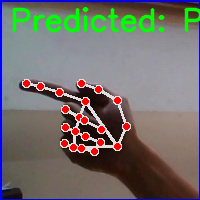

Prediction for 'G_test.jpg': Prediction Index Out of Bounds or Invalid: G


In [ ]:
# --- 4. Predict from Uploaded Image ---

import os
import mediapipe as mp
import cv2
import numpy as np
import joblib
from google.colab import files
from google.colab.patches import cv2_imshow

# Load model and label map
model_load_path = '/content/drive/MyDrive/knn_asl_model.pkl'
label_map_path = '/content/drive/MyDrive/knn_asl_label_map.npy'
if not os.path.exists(model_load_path) or not os.path.exists(label_map_path):
    print("Model or label map not found. Please run training first.")
    exit()
knn_model = joblib.load(model_load_path)
label_map = np.load(label_map_path)
print(f"Loaded label map: {label_map}")

# Mediapipe setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
mp_drawing = mp.solutions.drawing_utils

print("Upload an image for prediction:")
uploaded = files.upload()
if not uploaded:
    print("No file uploaded.")
else:
    for fn in uploaded.keys():
        img_bytes = uploaded[fn]
        np_arr = np.frombuffer(img_bytes, np.uint8)
        frame = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
        if frame is None:
            print(f"Could not decode image '{fn}'.")
            continue
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)
        predicted_sign = "No Hand Detected"
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                if hasattr(knn_model, 'n_features_in_') and len(landmarks) == knn_model.n_features_in_:
                    pred = knn_model.predict(np.array(landmarks).reshape(1, -1))[0]
                    predicted_sign = pred
                else:
                    predicted_sign = "Feature mismatch"
        cv2.putText(frame, f"Predicted: {predicted_sign}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2_imshow(frame)
        print(f"Prediction for '{fn}': {predicted_sign}")